In [1]:
import random
import tensorflow as tf
import numpy as np
import os
import re
import tensorflow_hub as hub


from keras.layers import Layer
from keras import backend as K
import keras.layers as layers
from keras.models import Model, load_model
from keras.models import Sequential
from keras.models import Model
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer

Using TensorFlow backend.


In [2]:
tf.test.is_gpu_available()

True

#### Initialize Session

In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.compat.v1.Session(config=config)
sess.run(tf.global_variables_initializer())
K.set_session(sess)

### Prepare the Data

In [4]:
data = pd.read_csv('dataset/data/articles_dataset.csv')
data = data[~data['content'].isnull()]
data.head()

,title,content,link,source,class
0,Tibit Communications Raises $20M in Series B F...,"Tibit Communications, Inc., a Petaluma, CA-bas...",http://www.finsmes.com/2019/04/tibit-communica...,FinsmesUSA,Funding
1,Twitter blames human error after blocking a Ne...,"Over the holiday weekend, The New York Times f...",https://techcrunch.com/2017/11/27/twitter-blam...,techcrunch,Other
2,SimplyCook Raises £4.5M in Series A Funding\n,"SimplyCook, a London, UK-based recipe kit serv...",http://www.finsmes.com/2019/01/simplycook-rais...,FinsmesUK,Funding
3,Moogsoft Secures $40M in Series D Funding\n,"Moogsoft, a San Francisco, CA-based provider o...",http://www.finsmes.com/2018/03/moogsoft-secure...,FinsmesUSA,Funding
4,Zeta Global acquires commenting service†Disqus,A source close to the two companies tells us t...,https://techcrunch.com/2017/12/05/zeta-global-...,techcrunch,Other


In [5]:
articles = data['content'].values
titles = data['title'].values
labels = data['class'].values

In [6]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)


def encode_labels(labels):
    encoded = label_encoder.transform(labels)
    return encoded

def decode_labels(encoded_labels):
    labels_type = type(encoded_labels)
    
    if labels_type == int:
        try:
            label = label_encoder.inverse_transform([encoded_labels])
        except ValueError:
            print('Unknown value')
            return np.nan
        
        return label
    
    elif hasattr(encoded_labels, '__iter__') and labels_type != str:
        try:
            labels = label_encoder.inverse_transform(encoded_labels)
            
        except ValueError:
            print('Unknown value')
            raise
            
        return labels
    else:
        raise TypeError

#### Reduce articles to 150 words

In [7]:
articles = np.array([' '.join(article.split()[:150]) for article in articles])

#### Create training, dev and test data

In [8]:
data_size = len(articles)

train_size = round(0.8 * data_size)
dev_size = round(0.1 * data_size)

dev_end = train_size + dev_size

print(train_size, dev_size, dev_end)

35225 4403 39628


In [9]:
shuffle = np.random.permutation(len(articles))
articles = articles[shuffle]
titles = titles[shuffle]
labels = labels[shuffle]

articles_train, labels_train, titles_train = articles[:train_size], labels[:train_size], titles[:train_size]
articles_dev, labels_dev, titles_dev = articles[train_size:dev_end], labels[train_size:dev_end], titles[train_size:dev_end]
articles_test, labels_test, titles_test = articles[dev_end:], labels[dev_end:], titles[dev_end:]

### Model Building

#### Function to plot learning curves

In [10]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

#### Create the Elmo Embedding Layer

In [11]:
class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
        self.dimensions = 1024
        self.trainable=True
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/2', trainable=self.trainable,
                               name="{}_module".format(self.name))

        self.trainable_weights += K.tf.trainable_variables(scope="^{}_module/.*".format(self.name))
        super(ElmoEmbeddingLayer, self).build(input_shape)

    def call(self, x, mask=None):
        result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1),
                      as_dict=True,
                      signature='default',
                      )['default']
        return result

    def compute_mask(self, inputs, mask=None):
        return K.not_equal(inputs, '--PAD--')

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dimensions)

#### Function to build an elmo model

In [12]:
# def build_model(): 
#   input_text = layers.Input(shape=(1,), dtype="string")
#   embedding = ElmoEmbeddingLayer()(input_text)
#   dense = layers.Dense(20, activation='relu')(embedding)
#   pred = layers.Dense(1, activation='sigmoid')(dense)

#   model = Model(inputs=[input_text], outputs=pred)

#   model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#   model.summary()
  
#   return model

In [13]:
# #Build the model
# model = build_model()

W0731 03:30:30.322214 139856200791872 deprecation_wrapper.py:119] From /home/brianmusisi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0731 03:30:30.323782 139856200791872 deprecation_wrapper.py:119] From /home/brianmusisi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0731 03:30:52.794257 139856200791872 deprecation_wrapper.py:119] From /home/brianmusisi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0731 03:30:52.820260 139856200791872 deprecation_wrapper.py:119] From /home/brianmusisi/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimize

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
elmo_embedding_layer_1 (Elmo (None, 1024)              4         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                20500     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 20,525
Trainable params: 20,525
Non-trainable params: 0
_________________________________________________________________


In [14]:
# # Build and fit
# history = model.fit(articles_train, labels_train,
#                   validation_data=(articles_dev, labels_dev),
#                     epochs=5, batch_size=128)

W0731 03:30:53.307352 139856200791872 deprecation_wrapper.py:119] From /home/brianmusisi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 35225 samples, validate on 4403 samples
Epoch 1/5
35225/35225 [==============================] - 354s 10ms/step - loss: 0.3814 - acc: 0.8372 - val_loss: 0.3325 - val_acc: 0.8608
Epoch 2/5
35225/35225 [==============================] - 318s 9ms/step - loss: 0.3230 - acc: 0.8685 - val_loss: 0.3129 - val_acc: 0.8774
Epoch 3/5
35225/35225 [==============================] - 316s 9ms/step - loss: 0.3086 - acc: 0.8755 - val_loss: 0.3292 - val_acc: 0.8596
Epoch 4/5
35225/35225 [==============================] - 310s 9ms/step - loss: 0.2962 - acc: 0.8789 - val_loss: 0.2958 - val_acc: 0.8826
Epoch 5/5
35225/35225 [==============================] - 308s 9ms/step - loss: 0.2877 - acc: 0.8833 - val_loss: 0.2851 - val_acc: 0.8894


In [20]:
# model.save('models/Elmo/Elmo_5_epocs.h5')

Training Accuracy: 0.8874
Testing Accuracy:  0.8894


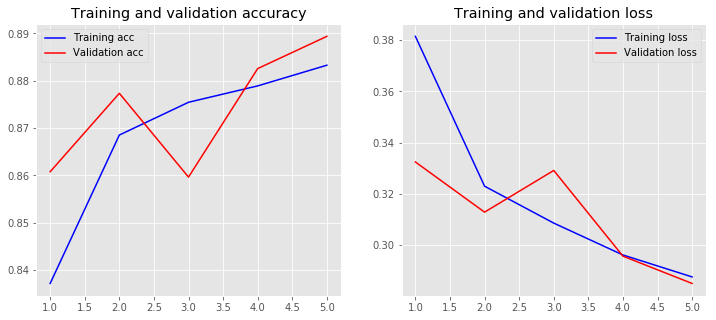

In [21]:
# loss, accuracy = model.evaluate(articles_train, labels_train, verbose=False)
# print("Training Accuracy: {:.4f}".format(accuracy))
# loss, accuracy = model.evaluate(articles_dev, labels_dev, verbose=False)
# print("Testing Accuracy:  {:.4f}".format(accuracy))
# plot_history(history)

#### Using 30 epochs

In [23]:
# # Build and fit
# model.reset_states()
# history = model.fit(articles_train, labels_train,
#                   validation_data=(articles_dev, labels_dev),
#                     epochs=30, batch_size=128)

Train on 35225 samples, validate on 4403 samples
Epoch 1/30
35225/35225 [==============================] - 304s 9ms/step - loss: 0.2801 - acc: 0.8861 - val_loss: 0.2828 - val_acc: 0.8864
Epoch 2/30
35225/35225 [==============================] - 315s 9ms/step - loss: 0.2750 - acc: 0.8875 - val_loss: 0.2880 - val_acc: 0.8871
Epoch 3/30
35225/35225 [==============================] - 320s 9ms/step - loss: 0.2717 - acc: 0.8896 - val_loss: 0.2826 - val_acc: 0.8828
Epoch 4/30
35225/35225 [==============================] - 319s 9ms/step - loss: 0.2692 - acc: 0.8894 - val_loss: 0.2755 - val_acc: 0.8889
Epoch 5/30
35225/35225 [==============================] - 321s 9ms/step - loss: 0.2627 - acc: 0.8934 - val_loss: 0.2912 - val_acc: 0.8810
Epoch 6/30
35225/35225 [==============================] - 322s 9ms/step - loss: 0.2609 - acc: 0.8936 - val_loss: 0.2732 - val_acc: 0.8901
Epoch 7/30
35225/35225 [==============================] - 321s 9ms/step - loss: 0.2570 - acc: 0.8936 - val_loss: 0.2813 - v

Training Accuracy: 0.9166
Testing Accuracy:  0.8876


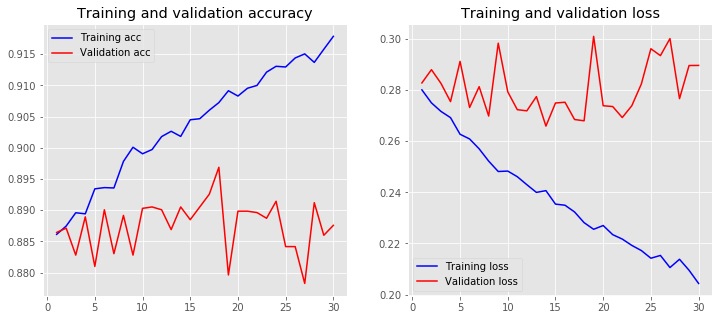

In [24]:
# loss, accuracy = model.evaluate(articles_train, labels_train, verbose=False)
# print("Training Accuracy: {:.4f}".format(accuracy))
# loss, accuracy = model.evaluate(articles_dev, labels_dev, verbose=False)
# print("Testing Accuracy:  {:.4f}".format(accuracy))
# plot_history(history)

In [25]:
# model.save('models/Elmo/Elmo_30epochs.h5')

### Use LSTM

In [11]:
### Early Stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

#### Change Elmo Embedding Layer to return "Elmo"

In [17]:
class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
        self.dimensions = 1024
        self.trainable=True
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/2', trainable=self.trainable,
                               name="{}_module".format(self.name))

        self.trainable_weights += K.tf.trainable_variables(scope="^{}_module/.*".format(self.name))
        super(ElmoEmbeddingLayer, self).build(input_shape)

    def call(self, x, mask=None):
        result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1),
                      as_dict=True,
                      signature='default',
                      )['elmo']
        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 48, self.dimensions)

In [12]:
def build_model(): 
    input_text = layers.Input(shape=(1,), dtype="string")
    embedding = ElmoEmbeddingLayer()(input_text)
    lstm = layers.LSTM(256)(embedding)
    dense = layers.Dense(10, activation='relu')(lstm)
    pred = layers.Dense(1, activation='sigmoid')(dense)

    model = Model(inputs=[input_text], outputs=pred)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    return model

In [13]:
model = build_model()

W0731 10:36:57.629750 140445795915584 deprecation_wrapper.py:119] From /home/brianmusisi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0731 10:36:57.634749 140445795915584 deprecation_wrapper.py:119] From /home/brianmusisi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0731 10:36:58.706564 140445795915584 deprecation_wrapper.py:119] From /home/brianmusisi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0731 10:36:59.031333 140445795915584 deprecation_wrapper.py:119] From /home/brianmusisi/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimize

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
elmo_embedding_layer_1 (Elmo (None, 48, 1024)          4         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 1,314,329
Trainable params: 1,314,329
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Build and fit
model.reset_states()
history = model.fit(articles_train, labels_train,
                  validation_data=(articles_dev, labels_dev),
                    epochs=10, batch_size=128, callbacks=[early_stop])

W0731 10:39:48.635360 140445795915584 deprecation_wrapper.py:119] From /home/brianmusisi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 35225 samples, validate on 4403 samples
Epoch 1/10
35225/35225 [==============================] - 363s 10ms/step - loss: 0.2828 - acc: 0.8872 - val_loss: 0.2280 - val_acc: 0.9094
Epoch 2/10
35225/35225 [==============================] - 326s 9ms/step - loss: 0.2067 - acc: 0.9214 - val_loss: 0.2206 - val_acc: 0.9151
Epoch 3/10
35225/35225 [==============================] - 325s 9ms/step - loss: 0.1840 - acc: 0.9298 - val_loss: 0.2158 - val_acc: 0.9266
Epoch 4/10
35225/35225 [==============================] - 327s 9ms/step - loss: 0.1580 - acc: 0.9393 - val_loss: 0.2272 - val_acc: 0.9162
Epoch 5/10
35225/35225 [==============================] - 326s 9ms/step - loss: 0.1259 - acc: 0.9515 - val_loss: 0.2428 - val_acc: 0.9119
Epoch 6/10
35225/35225 [==============================] - 341s 10ms/step - loss: 0.0954 - acc: 0.9646 - val_loss: 0.2705 - val_acc: 0.9110
Epoch 00006: early stopping


Training Accuracy: 0.9785
Testing Accuracy:  0.9110


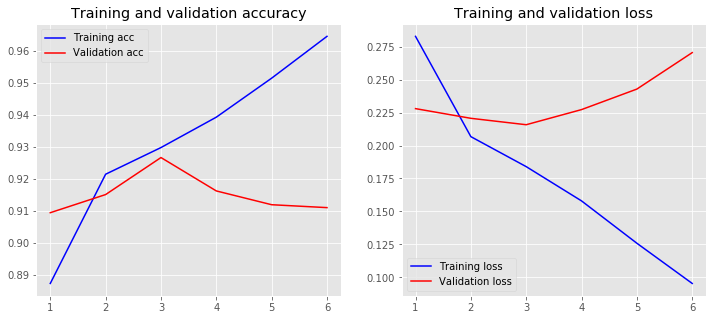

In [18]:
loss, accuracy = model.evaluate(articles_train, labels_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(articles_dev, labels_dev, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [19]:
model.save('models/Elmo/Elmo_10epochs_LSTM_512.h5')

#### LSTM with 512 units

In [24]:
def build_model(): 
    input_text = layers.Input(shape=(1,), dtype="string")
    embedding = ElmoEmbeddingLayer()(input_text)
    lstm = layers.LSTM(512)(embedding)
    dense = layers.Dense(30, activation='relu')(lstm)
    pred = layers.Dense(1, activation='sigmoid')(dense)

    model = Model(inputs=[input_text], outputs=pred)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    return model

In [25]:
model = build_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
elmo_embedding_layer_2 (Elmo (None, 48, 1024)          4         
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)               3147776   
_________________________________________________________________
dense_3 (Dense)              (None, 30)                15390     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 31        
Total params: 3,163,201
Trainable params: 3,163,201
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Build and fit
model.reset_states()
history = model.fit(articles_train, labels_train,
                  validation_data=(articles_dev, labels_dev),
                    epochs=10, batch_size=128, callbacks=[early_stop])

Train on 35225 samples, validate on 4403 samples
Epoch 1/10
35225/35225 [==============================] - 340s 10ms/step - loss: 0.2878 - acc: 0.8844 - val_loss: 0.2219 - val_acc: 0.9205
Epoch 2/10
35225/35225 [==============================] - 344s 10ms/step - loss: 0.2103 - acc: 0.9200 - val_loss: 0.2299 - val_acc: 0.9080
Epoch 3/10
35225/35225 [==============================] - 337s 10ms/step - loss: 0.1846 - acc: 0.9290 - val_loss: 0.2167 - val_acc: 0.9237
Epoch 4/10
35225/35225 [==============================] - 334s 9ms/step - loss: 0.1561 - acc: 0.9398 - val_loss: 0.2294 - val_acc: 0.9226
Epoch 5/10
35225/35225 [==============================] - 331s 9ms/step - loss: 0.1231 - acc: 0.9524 - val_loss: 0.2499 - val_acc: 0.9214
Epoch 6/10
35225/35225 [==============================] - 327s 9ms/step - loss: 0.0924 - acc: 0.9651 - val_loss: 0.2931 - val_acc: 0.9114
Epoch 00006: early stopping


In [27]:
model.save('models/Elmo/Elmo_10epochs_LSTM_512.h5')

Training Accuracy: 0.9779
Testing Accuracy:  0.9114


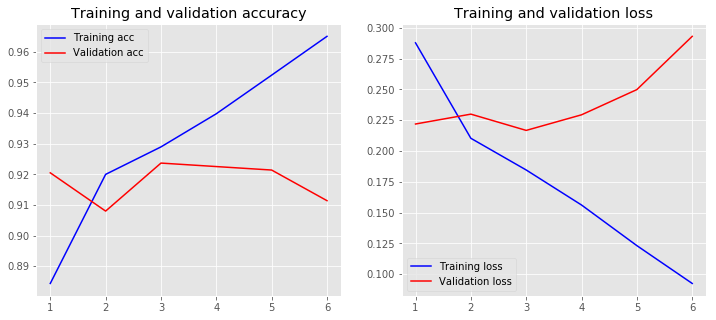

In [28]:
loss, accuracy = model.evaluate(articles_train, labels_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(articles_dev, labels_dev, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [29]:
loss, accuracy = model.evaluate(articles_test, labels_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.9164


### Use Bi-Directional LSTM

In [15]:
### Early Stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [16]:
def build_model(): 
    input_text = layers.Input(shape=(1,), dtype="string")
    embedding = ElmoEmbeddingLayer()(input_text)
    lstm = layers.Bidirectional(layers.LSTM(512))(embedding)
    dense = layers.Dense(128, activation='relu')(lstm)
    pred = layers.Dense(1, activation='sigmoid')(dense)

    model = Model(inputs=[input_text], outputs=pred)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    return model

In [17]:
model = build_model()

W0802 17:20:41.842910 140702634985280 deprecation_wrapper.py:119] From /home/brianmusisi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0802 17:20:41.845482 140702634985280 deprecation_wrapper.py:119] From /home/brianmusisi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0802 17:20:42.979758 140702634985280 deprecation_wrapper.py:119] From /home/brianmusisi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0802 17:20:44.671966 140702634985280 deprecation_wrapper.py:119] From /home/brianmusisi/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimize

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
elmo_embedding_layer_1 (Elmo (None, 48, 1024)          4         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1024)              6295552   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 6,426,885
Trainable params: 6,426,885
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.reset_states()
history = model.fit(articles_train, labels_train,
                  validation_data=(articles_dev, labels_dev),
                    epochs=10, batch_size=256, callbacks=[early_stop])

W0802 17:20:49.949066 140702634985280 deprecation_wrapper.py:119] From /home/brianmusisi/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 35225 samples, validate on 4403 samples
Epoch 1/10
35225/35225 [==============================] - 318s 9ms/step - loss: 0.3190 - acc: 0.8618 - val_loss: 0.2746 - val_acc: 0.8885
Epoch 2/10
35225/35225 [==============================] - 311s 9ms/step - loss: 0.2060 - acc: 0.9206 - val_loss: 0.2188 - val_acc: 0.9107
Epoch 3/10
35225/35225 [==============================] - 312s 9ms/step - loss: 0.1729 - acc: 0.9334 - val_loss: 0.2166 - val_acc: 0.9178
Epoch 4/10
35225/35225 [==============================] - 310s 9ms/step - loss: 0.1330 - acc: 0.9490 - val_loss: 0.2320 - val_acc: 0.9176
Epoch 5/10
35225/35225 [==============================] - 311s 9ms/step - loss: 0.0857 - acc: 0.9674 - val_loss: 0.3214 - val_acc: 0.9089
Epoch 6/10
35225/35225 [==============================] - 310s 9ms/step - loss: 0.0565 - acc: 0.9785 - val_loss: 0.3226 - val_acc: 0.9023
Epoch 00006: early stopping


In [ ]:
loss, accuracy = model.evaluate(articles_train, labels_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(articles_dev, labels_dev, verbose=False)
print("Dev Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [19]:
loss, accuracy = model.evaluate(articles_test, labels_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.9085


In [20]:
model.save('models/Elmo/Elmo_BiLSTM_512_128.h5')

### HyperParameter Tuning using Random Search

#### Elmo + Bi-LSTM

In [24]:
def build_model(lstm_size, dense_layer_sizes): 
    input_text = layers.Input(shape=(1,), dtype="string")
    embedding = ElmoEmbeddingLayer()(input_text)
    dense = layers.Bidirectional(layers.LSTM(lstm_size))(embedding)
    
    for dense_layer_size in dense_layer_sizes:
        dense = layers.Dense(dense_layer_size, activation='relu')(dense)
    
    #dense = layers.Dense(30, activation='relu')(lstm)
    pred = layers.Dense(1, activation='sigmoid')(dense)

    model = Model(inputs=[input_text], outputs=pred)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    #model.summary()

    return model

In [25]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

In [27]:
number_of_trials = 12

lstm_sizes_list = [128, 256, 512]
dense_layer_number_list = [1,2,3]
dense_layer_sizes_list = [30, 50, 128, 256]

best_val_accuracy = 0
best_parameters = {}

for trial in range(number_of_trials):
    
    lstm_size = random.choice(lstm_sizes_list)
    dense_layer_number = random.choice(dense_layer_number_list)
    dense_layer_sizes = random.choices(dense_layer_sizes_list, k=dense_layer_number)
    dev_accuracy = random.choice(range(100))
    
    model = build_model(lstm_size, dense_layer_sizes)
    
    history = model.fit(articles_train, labels_train,
                  validation_data=(articles_dev, labels_dev),
                    epochs=10, batch_size=128, callbacks=[early_stop])
    
    dev_loss, dev_accuracy = model.evaluate(articles_dev, labels_dev, verbose=False)
    print("Dev Accuracy:  {:.4f}".format(dev_accuracy))
    
    if dev_accuracy > best_val_accuracy:
        best_val_accuracy = dev_accuracy
        
        best_parameters['lstm_size'] = lstm_size
        best_parameters['dense_layer_sizes'] = dense_layer_sizes
        
print('The best accuracy is: {}'.format(best_val_accuracy))

Train on 35225 samples, validate on 4403 samples
Epoch 1/10
35225/35225 [==============================] - 384s 11ms/step - loss: 0.2782 - acc: 0.8888 - val_loss: 0.2174 - val_acc: 0.9198
Epoch 2/10
35225/35225 [==============================] - 375s 11ms/step - loss: 0.2023 - acc: 0.9222 - val_loss: 0.2044 - val_acc: 0.9226
Epoch 3/10
35225/35225 [==============================] - 375s 11ms/step - loss: 0.1737 - acc: 0.9325 - val_loss: 0.2077 - val_acc: 0.9237
Epoch 4/10
35225/35225 [==============================] - 378s 11ms/step - loss: 0.1337 - acc: 0.9476 - val_loss: 0.2678 - val_acc: 0.8973
Epoch 5/10
35225/35225 [==============================] - 378s 11ms/step - loss: 0.0897 - acc: 0.9645 - val_loss: 0.3050 - val_acc: 0.9151
Epoch 6/10
35225/35225 [==============================] - 377s 11ms/step - loss: 0.0605 - acc: 0.9758 - val_loss: 0.3810 - val_acc: 0.9117
Epoch 00006: early stopping
Dev Accuracy:  0.9117
Train on 35225 samples, validate on 4403 samples
Epoch 1/10
35225/3

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



35225/35225 [==============================] - 375s 11ms/step - loss: 0.1278 - acc: 0.9498 - val_loss: 0.2634 - val_acc: 0.9117
Epoch 5/10
35225/35225 [==============================] - 378s 11ms/step - loss: 0.0886 - acc: 0.9656 - val_loss: 0.3259 - val_acc: 0.8933
Epoch 6/10
35225/35225 [==============================] - 377s 11ms/step - loss: 0.0635 - acc: 0.9755 - val_loss: 0.3684 - val_acc: 0.8964
Epoch 7/10
35225/35225 [==============================] - 376s 11ms/step - loss: 0.0388 - acc: 0.9852 - val_loss: 0.4345 - val_acc: 0.9071
Epoch 00007: early stopping
Dev Accuracy:  0.9071
Train on 35225 samples, validate on 4403 samples
Epoch 1/10
35225/35225 [==============================] - 389s 11ms/step - loss: 0.2800 - acc: 0.8874 - val_loss: 0.2144 - val_acc: 0.9187
Epoch 2/10
35225/35225 [==============================] - 377s 11ms/step - loss: 0.1989 - acc: 0.9226 - val_loss: 0.2099 - val_acc: 0.9189
Epoch 3/10
35225/35225 [==============================] - 377s 11ms/step - los

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



35225/35225 [==============================] - 375s 11ms/step - loss: 0.0449 - acc: 0.9840 - val_loss: 0.3452 - val_acc: 0.9144
Epoch 00007: early stopping
Dev Accuracy:  0.9144
Train on 35225 samples, validate on 4403 samples
Epoch 1/10
35225/35225 [==============================] - 391s 11ms/step - loss: 0.2858 - acc: 0.8844 - val_loss: 0.2233 - val_acc: 0.9187
Epoch 2/10
35225/35225 [==============================] - 381s 11ms/step - loss: 0.1646 - acc: 0.9365 - val_loss: 0.2188 - val_acc: 0.9228
Epoch 4/10
35225/35225 [==============================] - 376s 11ms/step - loss: 0.1192 - acc: 0.9531 - val_loss: 0.2327 - val_acc: 0.9144
Epoch 5/10
35225/35225 [==============================] - 377s 11ms/step - loss: 0.0457 - acc: 0.9839 - val_loss: 0.3864 - val_acc: 0.9151
Epoch 00006: early stopping
Dev Accuracy:  0.9151
Train on 35225 samples, validate on 4403 samples
Epoch 1/10
35225/35225 [==============================] - 392s 11ms/step - loss: 0.2916 - acc: 0.8830 - val_loss: 0.21

In [28]:
print('The best accuracy is {:.4f}'.format(best_val_accuracy))

The best accuracy is 0.9173


In [29]:
print('The best parameters are:')
print(best_parameters)

The best parameters are:
{'lstm_size': 256, 'dense_layer_sizes': [30, 256, 30]}


#### Build model with best parameters

In [30]:
model = build_model(best_parameters['lstm_size'], best_parameters['dense_layer_sizes'])

history = model.fit(articles_train, labels_train,
              validation_data=(articles_dev, labels_dev),
                epochs=10, batch_size=128, callbacks=[early_stop])

Train on 35225 samples, validate on 4403 samples
Epoch 1/10
35225/35225 [==============================] - 400s 11ms/step - loss: 0.2872 - acc: 0.8856 - val_loss: 0.2214 - val_acc: 0.9176
Epoch 2/10
35225/35225 [==============================] - 380s 11ms/step - loss: 0.2025 - acc: 0.9230 - val_loss: 0.2092 - val_acc: 0.9246
Epoch 3/10
35225/35225 [==============================] - 379s 11ms/step - loss: 0.1731 - acc: 0.9328 - val_loss: 0.2106 - val_acc: 0.9260
Epoch 4/10
35225/35225 [==============================] - 379s 11ms/step - loss: 0.1336 - acc: 0.9459 - val_loss: 0.2569 - val_acc: 0.9121
Epoch 5/10
35225/35225 [==============================] - 379s 11ms/step - loss: 0.0942 - acc: 0.9621 - val_loss: 0.2778 - val_acc: 0.9044
Epoch 6/10
35225/35225 [==============================] - 378s 11ms/step - loss: 0.0686 - acc: 0.9740 - val_loss: 0.3235 - val_acc: 0.9139
Epoch 00006: early stopping


In [ ]:
loss, accuracy = model.evaluate(articles_test, labels_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [ ]:
model.save('models/Elmo/Elmo_BiLSTM_512_.h5')